In [1]:
# default_exp data_block
%load_ext autoreload
%autoreload 2

In [2]:
# hide
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# Data Block

> Primary handlers for interfacing the openai gym envs

In [3]:
# export
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
from fastrl.basic_train import *
from fastrl.wrappers import *
from dataclasses import asdict
from fastprogress.fastprogress import IN_NOTEBOOK
import torch.multiprocessing as mp
import logging
import gym

In [4]:
# hide
logging.basicConfig(format='[%(asctime)s] p%(process)s line:%(lineno)d %(levelname)s - %(message)s',
                    datefmt='%m-%d %H:%M:%S')
_logger=logging.getLogger(__name__)
_logger.setLevel('INFO')

## Dataset

`Dataset` instances are going to be a little different from the typically classification dataset that you might use in pytorch. Commonly, datasets have:
- A known size to iter through
- Maintain their state during the training sequence
- Randomly sample their dataset
- Have a common `x`/`y` or `input`/`target` data format

For our `ExperienceSourceDataset`, most of this is going to be different. 
- We can have multiple sources (envs)

You could think of a traditional dataset approach as being a mix of a `ExperienceSourceDataset` and a form of `ExperienceReplay`.

In [5]:
# export
def fix_s(x):
    "Flatten `x` to `(1,-1)` where `1` is the batch dim (B) unless **seems** to be an image e.g. has 3 dims (W,H,C), then it will attempt (B,W,H,C)."
    return (x if x.shape[0]==1 else 
            x.reshape(1,-1) if len(x.shape)==2 else
            np.expand_dims(x,0))

@dataclass
class Experience(object):
    s:np.array
    sp:np.array
    a:np.array
    r:np.array
    d:np.array
    agent_s:np.array
        
    def __post_init__(self):
        for k,v in asdict(self).items():
            setattr(self,k,fix_s(v) if k in ['s','sp'] else np.array(v,dtype=float).reshape(1,-1))

In [6]:
exp=Experience(s=np.random.randint(1,3,(5,5)),
               sp=np.random.randint(1,3,(5,5)),
               a=np.random.randint(1,3,(1,2)),
               r=np.random.randint(1,3,(1,20)),
               d=np.random.randint(0,1,(5,5)),
               agent_s=np.random.randint(0,6,(1,5)))
asdict(exp)

{'s': array([[2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2]]),
 'sp': array([[1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2]]),
 'a': array([[1., 1.]]),
 'r': array([[2., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 2., 1., 2., 1., 2.]]),
 'd': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'agent_s': array([[5., 5., 1., 3., 4.]])}

## Datasets

In [7]:
# export
class ExperienceSourceDataset(Dataset):
    "Similar to fastai's `LabelList`, iters in-order samples from `1->len(envs)` `envs`."
    def __init__(self,envs:Tuple[gym.Env,list,tuple],steps=1,max_episode_step=None):
        self.envs=listify(envs)
        self.steps=steps
        self.max_episode_step=max_episode_step
        self.d=np.zeros((len(self.envs),))+1
        self.s=np.zeros((len(self.envs),*self.envs[0].observation_space.sample().shape))
        self.interation=np.zeros((len(self.envs)))
        self.total_r=[]
        self.total_steps=[]
        self.learner=None
        
    def __len__(self): return ifnone(self.max_episode_step,self.envs[0].spec.max_episode_steps)
    
    def __getitem__(self,idx)->Tuple[Tuple[np.array],Dict]:
        idx=idx%len(self.envs)
        if idx==0 and self.interation[idx]==0:
            for i,e in enumerate(self.envs): self.s[i]=e.reset()                                   # There is the possiblity this will equal None (and crash)?
            self.interation=np.zeros((len(self.envs)))
        
        exps:List[Experience]=[]
        while True:
            a,agent_s=self.learner.predict(None,None)
            sp,r,self.d[idx],_=self.envs[idx].step(a)
            self.total_r.append(r)
            self.total_steps.append(self.interation[idx])
            exps.append(Experience(self.s[idx],sp,a,r,self.d[idx],agent_s=agent_s))
            self.s[idx]=sp
            self.interation[idx]+=1
            if len(exps)%self.steps==0:break
            if self.d[idx] or self.interation[idx]>=len(self):
                self.interation[idx]=0
                break
        return [e.s for e in exps],[asdict(e) for e in exps]

In [8]:
import sys
# make_env = lambda: gym.make("Acrobot-v1")
make_env = lambda: gym.make("CartPole-v1")
envs=[make_env() for _ in range(3)]
ds=ExperienceSourceDataset(envs,max_episode_step=50,steps=5)
dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
ds.learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)))
for xb,yb in dl:
    _logger.critical('xb: %s, yb: %s',torch.cat(xb).shape,yb[0].keys())
    assert torch.cat(xb).shape[0]<=5*3
    sys.stdout.flush()

[06-17 17:05:54] p134 line:9 CRITICAL - xb: torch.Size([15, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:54] p134 line:9 CRITICAL - xb: torch.Size([15, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:54] p134 line:9 CRITICAL - xb: torch.Size([6, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:54] p134 line:9 CRITICAL - xb: torch.Size([15, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:54] p134 line:9 CRITICAL - xb: torch.Size([15, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:54] p134 line:9 CRITICAL - xb: torch.Size([12, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
/opt/conda/envs/fastrl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined 

In [9]:
def make_env():
    env=gym.make("CartPole-v1")
    env.reset()
    return env
envs=[PixelObservationWrapper(make_env()) for _ in range(3)]
ds=ExperienceSourceDataset(envs,max_episode_step=50,steps=5)
dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
ds.learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)))
for xb,yb in dl:
    _logger.critical('xb: %s, yb: %s',torch.cat(xb).shape,yb[0].keys())
    assert torch.cat(xb).shape[0]<=5*3
    sys.stdout.flush()

[06-17 17:05:55] p134 line:10 CRITICAL - xb: torch.Size([15, 1, 400, 600, 3]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:55] p134 line:10 CRITICAL - xb: torch.Size([15, 1, 400, 600, 3]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:55] p134 line:10 CRITICAL - xb: torch.Size([3, 1, 400, 600, 3]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
/opt/conda/envs/fastrl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
[06-17 17:05:55] p134 line:10 CRITICAL - xb: torch.Size([3, 1, 400, 600, 3]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:56] p134 line:10 CRITICAL - xb: torch.Size([15, 1, 400, 600, 3]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'a

In [10]:
# export
class FirstLastExperienceSourceDataset(ExperienceSourceDataset):
    "Similar to `ExperienceSourceDataset` but only keeps the first and last parts of a step. Can be seen as frame skipping."
    def __getitem__(self,idx)->Tuple[Tuple[np.array],Dict]:
        s,exps=super(FirstLastExperienceSourceDataset,self).__getitem__(idx)
        exp=exps[-1]
        exp['s']=exps[0]['s']
        return [exps[0]['s']],[exp]

In [11]:
make_env = lambda: gym.make("CartPole-v1")
envs=[make_env() for _ in range(3)]
ds=FirstLastExperienceSourceDataset(envs,max_episode_step=50,steps=5)
dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
ds.learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)))
index=0
for xb,yb in dl:
    _logger.critical('xb: %s, yb: %s',torch.cat(xb).shape,yb[0].keys())
    assert torch.cat(xb).shape[0]<=3
    sys.stdout.flush()
    index+=1

[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - xb: torch.Size([3, 1, 4]), yb: dict_keys(['s', 'sp', 'a', 'r', 'd', 'agent_s'])
[06-17 17:05:57] p134 line:8 CRITICAL - 

In [12]:
# export
class AsyncExperienceSourceCallback(LearnerCallback):
    _order = -11
    
    def on_epoch_begin(self,**kwargs):
        if not self.learn.data.empty_val:
            ds=(self.learn.data.train_ds if self.learn.model.training else
                self.learn.data.valid_ds)
            ds.pause_event.clear()

            if len(ds.data_proc_list)==0:
                for proc_idx in range(ds.n_processes):
                    data_proc=mp.Process(target=getattr(self.learn,'grad_fitter',grad_fitter), 
                                         args=(self.learn.model,self.learn.data.device,
                                               ds.grad_queue,ds.loss_queue,ds.pause_event,ds.cancel_event))
                    data_proc.start()
                    ds.data_proc_list.append(data_proc)

    def on_batch_end(self,**kwargs):
        if not self.learn.data.empty_val:
            # If not training, pause train ds, otherwise pause valid ds
            ds=(self.learn.data.train_ds if not self.learn.model.training else
                self.learn.data.valid_ds)
            ds.pause_event.set()
    
    def on_train_end(self,**kwargs):
        _logger.info('Canceling Processes')
        for ds in [self.learn.data.train_ds,None if self.learn.data.empty_val else self.learn.data.valid_ds]:
            if ds is None: continue
            ds.cancel_event.set()
            while not ds.grad_queue.empty(): ds.grad_queue.get()
            while not ds.loss_queue.empty(): ds.loss_queue.get()
            _logger.info('Joining Processes')
            for proc in ds.data_proc_list: proc.join()

In [13]:
# export
def grad_fitter(model:nn.Module,ds:ExperienceSourceDataset,grad_queue:mp.JoinableQueue,loss_queue:mp.JoinableQueue,pause_event:mp.Event,cancel_event:mp.Event):
    "Updates a `train_queue` with `model.parameters()` and `loss_queue` with the loss. Note that this is only an example grad_fitter."
    _logger.warning('Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.')
    while not cancel_event.is_set(): # We are expecting the  grad_fitter to loop unless cancel_event is set
        grad_queue.put(None)        #  Adding `None` to `train_queue` will trigger an eventual ending of training
        loss_queue.put(None)
        if pause_event.is_set():     # There needs to be the ability for the grad_fitter to pause e.g. if waiting for validation to end.
            cancel_event.wait(0.1)   # Using cancel_event to wait allows the main process to end this Process.

class AsyncGradExperienceSourceDataset(ExperienceSourceDataset):
    "Contains dataloaders of multiple sub-datasets and executes them using `n_processes`. `xb` is the gradients from the agents, `yb` is the loss."
    def __init__(self,envs,n_processes,learner_cls=AgentLearner,ds_cls=ExperienceSourceDataset,max_episode_step=None,*args,**kwargs):
        self.n_processes=n_processes
        self.envs=envs
        self.pause_event=mp.Event()                               # If the event is set, then the Process will freeze.
        self.cancel_event=mp.Event()                              # If the event is set, then the Process will freeze.
        self.max_episode_step=max_episode_step
        self.grad_queue=mp.JoinableQueue(maxsize=self.n_processes)
        self.loss_queue=mp.JoinableQueue(maxsize=self.n_processes)
        self.data_proc_list=[]
        
    def __getitem__(self,idx)->Tuple[Tuple[np.array],Dict]:
        if len(self.data_proc_list)==0: raise StopIteration()
        train_entry=self.grad_queue.get()

        if train_entry is None:
            raise StopIteration()
        
        train_loss_entry=self.loss_queue.get()
        return train_entry,[train_loss_entry]      


In [14]:
make_env = lambda: gym.make("CartPole-v1")
envs=[make_env() for _ in range(3)]
ds=AsyncGradExperienceSourceDataset(envs,12,max_episode_step=50,steps=5)
dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)))
callback=AsyncExperienceSourceCallback(learner)
index=0
callback.on_epoch_begin()
for xb,yb in dl:
    _logger.critical('xb: %s, yb: %s',torch.cat(xb).shape,yb[0].keys())
    assert torch.cat(xb).shape[0]<=3
    sys.stdout.flush()
    index+=1
callback.on_train_end()

[06-17 17:05:57] p211 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 17:05:57] p214 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 17:05:57] p219 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 17:05:57] p222 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 17:05:57] p225 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 17:05:57] p228 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 17:05:57] p231 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 17:05:57] p235 line:4 WARNING - Using the `test_fitter` function. Make sure your `AgentLearner` has a `grad_fitter`.
[06-17 1

## Dataset Shower
We can define a wrapper around a dataset which will show up to `rows * cols` environments.

In [204]:
# export
if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

In [205]:
%matplotlib inline

In [210]:
# export
class DatasetDisplayWrapper(object):
    def __init__(self,ds,rows=2,cols=2,max_w=800):
        "Wraps a ExperienceSourceDataset instance showing multiple envs in a `rows` by `cols` grid in a Jupyter notebook."
        # Ref: https://stackoverflow.com/questions/1443129/completely-wrap-an-object-in-python
        # We are basically Wrapping any instance of ExperienceSourceDataset (kind of cool right?)
        self.__class__ = type(ds.__class__.__name__,(self.__class__, ds.__class__),{})
        self.__dict__=ds.__dict__
        self.rows,self.cols,self.max_w=rows,cols,max_w
        self.current_display=None
        if not IN_NOTEBOOK: 
            _logger.warning('It seems you are not running in a notebook. Nothing is going to be displayed.')
            return
        
        if self.envs[0].render('rgb_array') is None: self.envs[0].reset()
        rdr=self.envs[0].render('rgb_array')
        if rdr.shape[1]*self.cols>max_w:
            _logger.warning('Max Width is %s but %s*%s is greater than. Decreasing the number of cols to %s, rows increase by %s',
                            max_w,rdr.shape[1],self.cols,max_w%rdr.shape[1],max_w%rdr.shape[1])
            self.cols=max_w%rdr.shape[1]
            self.rows+=max_w%rdr.shape[1]

        self.current_display=np.zeros(shape=(self.rows*rdr.shape[0],self.cols*rdr.shape[1],rdr.shape[2])).astype('uint8')
        display.display(PIL.Image.fromarray(self.current_display))
        _logger.critical('%s, %s, %s, %s, %s',0,0//self.cols,0%self.cols,rdr.shape,self.current_display.shape)

    def __getitem__(self,idx)->Tuple[Tuple[np.array],Dict]:
        o=super(DatasetDisplayWrapper,self).__getitem__(idx)
        idx=idx%len(self.envs)
        if self.current_display is not None and idx<self.rows*self.cols:
            display.clear_output(wait=True)
            im=self.envs[idx].render(mode='rgb_array')
            self.current_display[(idx//self.cols)*im.shape[0]:(idx//self.cols)*im.shape[0]+im.shape[0],
                                 (idx%self.cols)*im.shape[1]:(idx%self.cols)*im.shape[1]+im.shape[1],:]=im
            new_im=PIL.Image.fromarray(self.current_display)
            display.display(new_im)
        return o

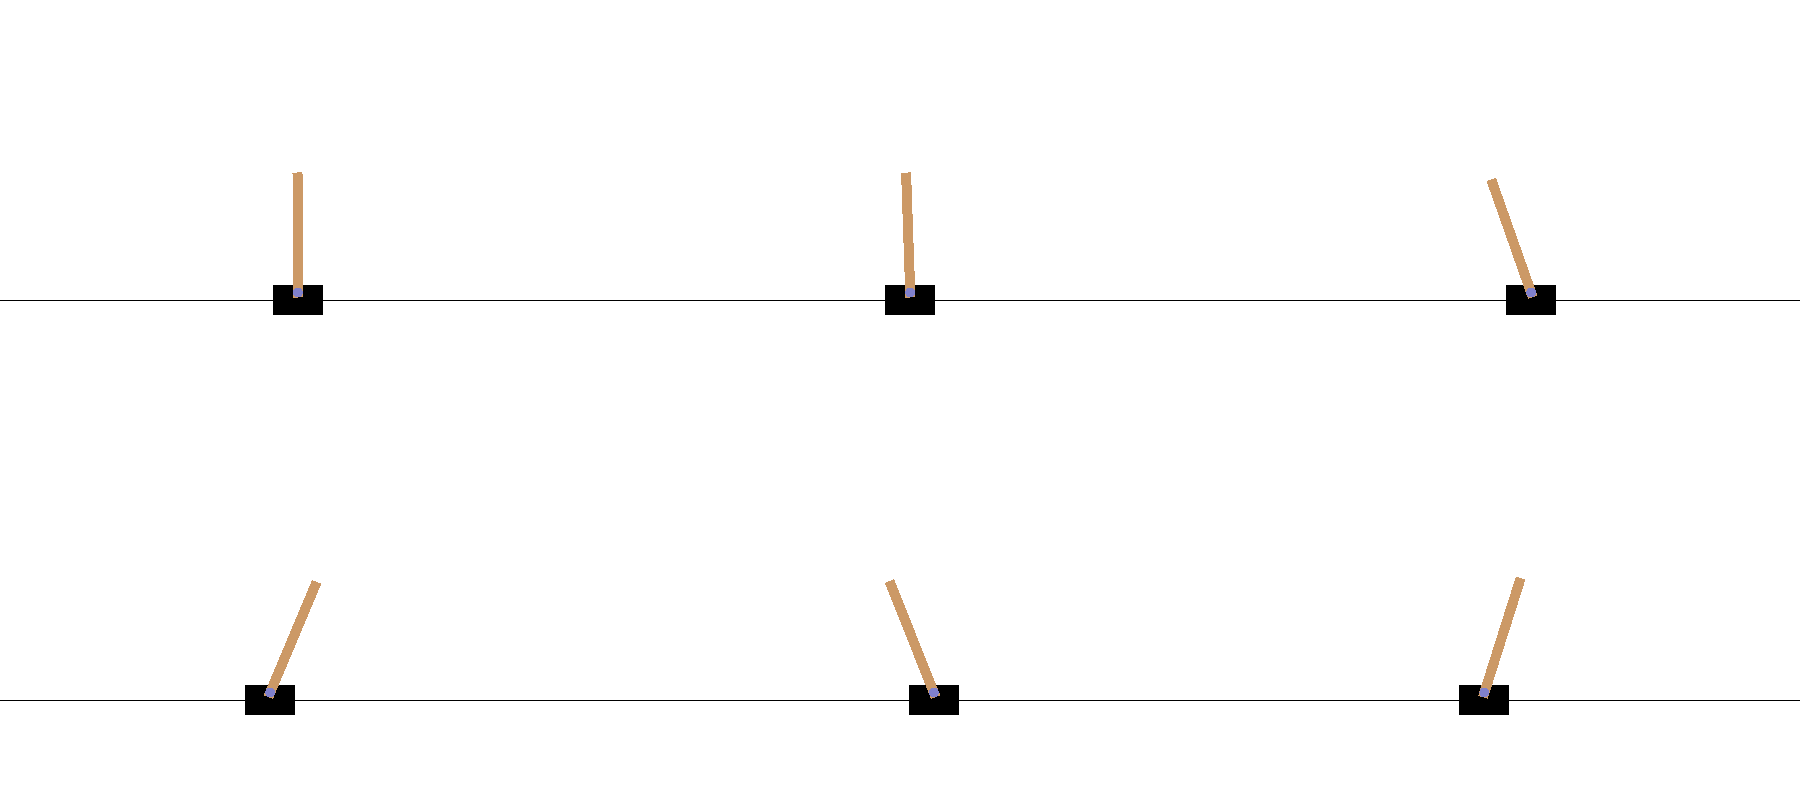

In [211]:
import sys
make_env = lambda: gym.make("CartPole-v1")
envs=[make_env() for _ in range(6)]
ds=ExperienceSourceDataset(envs,max_episode_step=50,steps=5)
ds=DatasetDisplayWrapper(ds,cols=3,rows=2,max_w=8000)
dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
ds.learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)))
for xb,yb in dl:
    assert torch.cat(xb).shape[0]<=5*6
    sys.stdout.flush()

In [212]:
# hide
from nbdev.export import *
notebook2script()
notebook2html(n_workers=0)

Converted 00_core.ipynb.
Converted 01_wrappers.ipynb.
Converted 02_basic_train.ipynb.
Converted 04_data_block.ipynb.
Converted index.ipynb.
Converted notes.ipynb.
converting: /opt/project/nbs/04_data_block.ipynb
